# Quick python introduction for Data scientist, using R

# # By Sven Dennis Kügler, March 2017

We start with load required packages & functions
Everything that is important comes with sklearn, matplotlib and numpy.
Pay attention with overwriting name space, especially for general function names, like "confusion_matrix".

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
np.random.seed(1423)

In addition, we load a file from the iris dataset and dump it as a csv. Please adjust the path to the CoE internal drive.

In [30]:
path = "Y:/02 CoE Department/06 CoE Weiterbildung/Python-Advanced Analytics/"

Now we are going to load the IRIS data set, note that this one is given as a dictionary, which is a very handy data format. We dump the dictionary to a csv file, including the respective header.

In [2]:
iris = datasets.load_iris()
allData = np.hstack((iris['data'], iris['target'][:,None]))
np.savetxt("iris_example.csv", allData ,header=','.join(iris['feature_names'])+',Target',  newline='\r\n', fmt="%.4f", delimiter=',')

To read such a file, two different approaches exist, reading it as data frame in pandas or as an array in numpy. To get some basics on pandas dataframes, refer to [Pandas+DataFrame+Operations.html](Pandas+DataFrame+Operations.html):

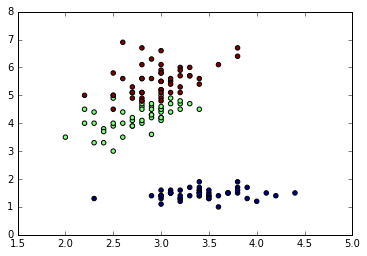

In [32]:
df = pd.read_csv(path+"iris_example.csv", sep=",", decimal=".", header="infer")
# first ten rows
res_iloc  = df.iloc[:10,:]
res_loc   = df.loc[:9,:]    #this is so stupid
# only column "Target"
res2_iloc = df.iloc[:,-1]
res2_loc  = df.loc[:,"Target"]
plt.scatter(df.iloc[:,1], df.iloc[:,2], c=df.loc[:,"Target"])
plt.show()

Usually I go the extra step and convert everything to a numpy array (or directly read it in as one):

In [33]:
data_as_array_from_df = np.asarray(df)
data_as_array_from_file_orig = np.genfromtxt(path+"iris_example.csv", delimiter=",",  skip_header=1)
print(np.all(data_as_array_from_df==data_as_array_from_file_orig))

True


Now arrays are quite tricky. Arrays are in python the generalization of matrices (there are no matrices) and you can do very cool, and fast things with them. But be aware: SINCE PYTHON 3.X LISTS, ARRAYS ARE SHALLOW-COPIED!!!!!! What does this mean:

In [34]:
list_ex = [1,2,3,4,5]
list_ex_copy = list_ex
list_ex_copy[0] += 1
print(list_ex_copy, list_ex) #they are the same

from copy import deepcopy
list_ex = [1,2,3,4,5]
list_ex_copy = deepcopy(list_ex)
list_ex_copy[0] += 1
print(list_ex_copy, list_ex) #they are different

[2, 2, 3, 4, 5] [2, 2, 3, 4, 5]
[2, 2, 3, 4, 5] [1, 2, 3, 4, 5]


Now, let us get to to the fancy things:

(2000, 20)


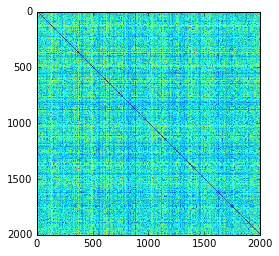

In [35]:
testM = np.random.uniform(size=(2000,20))
# dot product
dProd = np.dot(testM, testM.T)
# normalize the matrix
testM = (testM-np.sum(testM, axis=0)) / np.std(testM, axis=0)
print(testM.shape)

# calculate the distance matrix in a one-liner (note, however how much memory is theoretically used: 2000^2 * 200 Byte = 800 MB!)
DM = np.sum((testM[:,None,:] - testM[None,:,:])**2, axis=-1)

# Let's visualize something:
plt.imshow(DM)
plt.show()

So let us go to something more elaborate and train some random forests on the IRIS data, I hope this is self-explanatory.    
(To get started with sckit-learn algorithms, start with [scikit-learn+KNeighbors+Classifiers.html](scikit-learn+KNeighbors+Classifiers.html) and continue with [scikit-learn+Classifier.html](scikit-learn+Classifier.html):)

[[50  0  0]
 [ 0 49  1]
 [ 0  5 45]]
Score ignoring categorial nature:  14.964
Score respecting categorial nature:  12.465


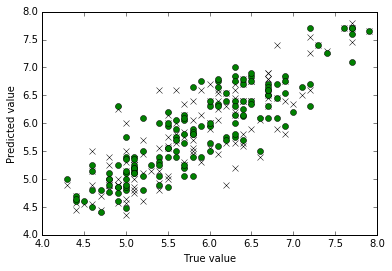

In [36]:
data_as_array_from_file_orig = np.genfromtxt(path+"iris_example.csv", delimiter=",",  skip_header=1)
# split into training & test
cv_bin = np.random.choice(range(10), size=(len(df.loc[:,"Target"])))
y_true = np.asarray([])
y_pred = np.asarray([])

# Run classification on cross-folds
for i in np.unique(cv_bin):
    RF = RandomForestClassifier(n_estimators=2, criterion="gini", n_jobs=8)
    RF.fit(df.iloc[cv_bin!=i,:-1].values, df.iloc[cv_bin!=i,-1].values)
    y_pred = np.hstack((y_pred, RF.predict(df.iloc[cv_bin==i,:-1].values)))
    y_true= np.hstack((y_true, df.iloc[cv_bin==i,-1].values))
print(confusion_matrix(y_true, y_pred))


y_true = np.asarray([])
y_pred = np.asarray([])
# Run regression, ignoring that the last column is a class
for i in np.unique(cv_bin):
    RF = RandomForestRegressor(n_estimators=2, n_jobs=8)
    RF.fit(df.iloc[cv_bin!=i,1:].values, df.iloc[cv_bin!=i,0].values)
    y_pred = np.hstack((y_pred, RF.predict(df.iloc[cv_bin==i,1:].values)))
    y_true= np.hstack((y_true, df.iloc[cv_bin==i,0].values))
print("Score ignoring categorial nature: ", round(0.5*np.sum((y_true-y_pred)**2), 3))
plt.plot(y_true, y_pred, 'kx')

y_true = np.asarray([])
y_pred = np.asarray([])
# Run regression, perform hot-1-encoding on the class - Note that there is no native way to deal with this
enc = OneHotEncoder()
res = enc.fit_transform(data_as_array_from_file_orig[:,-1].reshape(-1,1)).toarray()
data_as_array_from_file = np.hstack((data_as_array_from_file_orig[:,:-1], res))
for i in np.unique(cv_bin):
    RF = RandomForestRegressor(n_estimators=2, n_jobs=8)
    RF.fit(data_as_array_from_file[cv_bin!=i,1:], data_as_array_from_file[cv_bin!=i,0])
    y_pred = np.hstack((y_pred, RF.predict(data_as_array_from_file[cv_bin==i,1:])))
    y_true= np.hstack((y_true, data_as_array_from_file[cv_bin==i,0]))
print("Score respecting categorial nature: ", round(0.5*np.sum((y_true-y_pred)**2), 3))
plt.plot(y_true, y_pred, 'go')
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.show()